# Comparing Bandit Agents

The notebook (`compare.ipynb`) compares the performance of different bandit agents. The `compare.py` script is for command-line execution. They are automatically paired using `jupytext -s`. 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
from typing import List
import numpy as np
import multiprocessing

cores =  multiprocessing.cpu_count() - 1

In [2]:
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
from bart_playground.bandit.refresh_agent import RefreshDefaultBARTAgent, RefreshLogisticBARTAgent
from bart_playground.bart import DefaultBART, LogisticBART

from bart_playground.bandit.TEagents import TEAgent


from compare_agents import (
    AgentSpec, compare_agents_across_scenarios, print_summary_results, plot_comparison_results
)
from bart_playground.bandit.sim_util import _sim_logger, OpenMLScenario, FriedmanDScenario, FriedmanScenario, LinearScenario, GLMScenario, LinearFriedmanScenario
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario
from drinkless import DrinkLessScenario

### Initialization

In [3]:
# Initialize Numba

bart_ini = DefaultBART(ndpost=1, nskip=1, n_trees=25)
logistic_bart_ini = LogisticBART(ndpost=1, nskip=1, n_trees=25)

# Simple dataset
X_ini = np.random.uniform(-1, 1, size=(100, 1))
y_ini = np.sin(2 * np.pi * X_ini) + np.random.normal(0, 0.1, size=X_ini.shape)

bart_ini.fit(X_ini, y_ini)

Iterations: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


### Simulation Parameters

In [4]:
# default scenario
default_arg = ['Shuttle'] # ['DrinkLess', 'Wine', 'Heart', 'Iris']
# include more agent variations
extensive = True

n_simulations = 4  # Number of simulations per scenario
sim_indices = list(range(n_simulations))  # Indices for simulations
max_draws = 10000      # Number of draws per simulation

profile = False # Profile the simulation (if True, will use a profiler)

### Scenarios and Agents

In [5]:
has_gpu = True
try:
    import torch
    from bart_playground.bandit.neural_paper_agents import NeuralTSDiagAgent, LinearTSDiagAgent, KernelTSDiagAgent, NeuralTSAgent, NLinearTSAgent, NKernelTSAgent
except:
    has_gpu = False
    _sim_logger.warning("Neural agents not available. Skipping GPU-based agents.")

WARNING bandit_simulator — Neural agents not available. Skipping GPU-based agents.


#### Scenarios

In [6]:
# Create test scenarios
scenario_factories = {
    "Linear": lambda: LinearScenario(P=10, K=5, d=2, sigma2=1.0),
    "GLM": lambda: GLMScenario(P=5, K=5, sigma2=1.0),
    "Friedman": lambda: FriedmanScenario(P=10, K=2, sigma2=1.0),
    "Friedman2": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman2'),
    "Friedman3": lambda: FriedmanScenario(P=4, K=2, sigma2=1.0, f_type='friedman3'),
    "LinFriedman": lambda: LinearFriedmanScenario(P=10, K=2, sigma2=1.0),
    "Sparse": lambda: FriedmanScenario(P=20, K=5, sigma2=1.0),
    ## "Isolet": lambda: OpenMLScenario('isolet', version=1),
    "Magic": lambda: OpenMLScenario('MagicTelescope', version=1),
    "Adult": lambda: OpenMLScenario('adult', version=2),
    "Shuttle": lambda: OpenMLScenario('shuttle', version=1),
    ## "Letter": lambda: OpenMLScenario('letter', version=1),
    "Mushroom": lambda: OpenMLScenario('mushroom', version=1),
    "Covertype": lambda: OpenMLScenario('covertype', version=3),
    "MNIST": lambda: OpenMLScenario('mnist_784', version=1),
    "Iris": lambda: OpenMLScenario('iris', version=1),
    "Wine": lambda: OpenMLScenario('wine-quality-red', version=1),
    "Heart": lambda: OpenMLScenario('heart-disease', version=1,
                                    target_column='target'), # Cleveland Heart Disease dataset
    "DrinkLess": lambda: DrinkLessScenario(),
    
}

# Parse command-line arguments
args = sys.argv[1:]
cli = True

# Determine which scenarios to run; default if none or invalid
if len(args) == 0 or not any(arg in scenario_factories for arg in args):
    print(f"No valid scenarios specified, using {default_arg}.")
    args = default_arg
    cli = False

selected_keys = [k for k in scenario_factories if k in args]
scenarios = {key: scenario_factories[key]() for key in selected_keys}

rep_dataset = selected_keys[0]
# log_encoding = 'native' if rep_dataset in ['Adult', 'Magic', 'Mushroom'] else 'multi' 

if has_gpu:
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)

No valid scenarios specified, using ['Shuttle'].


#### Agents

In [7]:
all_agent_specs: List[AgentSpec] = []
more_agent_specs = []

if has_gpu:
    print("Has GPU, test NeuralTS agents") 
    all_agent_specs = [
        ("NeuralTSDiag", NeuralTSDiagAgent, {}),
        # ("NeuralTS", NeuralTSAgent, {}),
        ("NLinearTS", NLinearTSAgent, {}),
        ("NKernelTS", NKernelTSAgent, {}),
    ]
else:
    print("No GPU, test BART agents") 
    all_agent_specs = [
        ("Random",      SillyAgent,      {'random_state':0}),
        ("XGBoostTS", TEAgent, {'agent_type': 'xgboost'}),
        ("RFTS", TEAgent, {'agent_type': 'random_forest'}),
        # ("BARTs",       DefaultBARTAgent,       {}),
        ("BARTm",       DefaultBARTAgent,       {}),
        ("BARTo",       DefaultBARTAgent,       {}),
        # ("RefreshBARTs", RefreshDefaultBARTAgent, {}),
        ("RefreshBARTm", RefreshDefaultBARTAgent, {}),
        ("RefreshBARTo", RefreshDefaultBARTAgent, {}),
        # ("LogisticBARTm", LogisticBARTAgent, {}),
        # ("LogisticBARTo", LogisticBARTAgent, {}),
        # ("MCBARTs",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
        # ("MCBARTm",     MultiChainBARTAgent, { 'bart_class': DefaultBART }),
        # ("LogisticMCBARTm", MultiChainBARTAgent, { 'bart_class': LogisticBART }),
        ("LinearTS",   LinearTSAgent,   {'v':1}),
        # ("LinearTSme",  LinearTSAgent2,  {}),
        # ("RoME",             RoMEAgent,              {'featurize':_featurize, 't_max':n_draws, 'pool_users':False}),
        # ("StandardTS",       StandardTSAgent,        {'featurize':_featurize}),
        # ("ActionCenteredTS", ActionCenteredTSAgent,  {'featurize':_featurize}),
        # ("IntelligentPooling", IntelligentPoolingAgent, {'featurize':_featurize, 't_max':n_draws}),
        # ("BCF",        BCFAgent,        {'nskip':100, 'ndpost':100, 'nadd':3, 'nbatch':1, 'random_state':0}),
        # ("Ensemble",   EnsembleAgent,   {
        #     'bcf_kwargs':       dict(nskip=100, ndpost=10, nadd=2, random_state=0),
        #     'linear_ts_kwargs': dict(v=1)
        # }),
        # ("BCF_PSOff",  BCFAgentPSOff,   {'nskip':100, 'ndpost':10, 'nadd':2, 'nbatch':1, 'random_state':0}),
    ]

    # generate more agent specifications for parameter variations
    for agent_name, agent_class, agent_kwargs in all_agent_specs:
        agent_kwargs['random_state'] = 0
        if 'BART' in agent_name:
            agent_kwargs['nskip'] = 30
            agent_kwargs['ndpost'] = 30
            agent_kwargs['n_trees'] = 50 # default number of trees
            agent_kwargs['nadd'] = 1 # default number of additional iterations

            if 'BARTm' in agent_name:
                agent_kwargs['encoding'] = 'multi'
            elif 'BARTo' in agent_name:
                agent_kwargs['encoding'] = 'one-hot'
            elif 'BARTs' in agent_name:
                agent_kwargs['encoding'] = 'separate'
            
            if 'Refresh' in agent_name:
                agent_kwargs['nskip'] *= 20
                agent_kwargs['ndpost'] *= 20
                agent_kwargs.pop('nadd')  # Remove 'nadd'
                if 'BARTs' in agent_name:
                    agent_kwargs['nskip'] /= 2
                    agent_kwargs['ndpost'] /= 2
                    
                agent_kwargs_new = agent_kwargs.copy()
                agent_kwargs_new['nskip'] /= 2
                agent_kwargs_new['ndpost'] /= 2
                more_agent_specs.append((f"{agent_name}_iter0.5x", agent_class, agent_kwargs_new.copy()))

            if not 'MCBART' in agent_name:
                agent_kwargs_new = agent_kwargs.copy()
                # agent_kwargs_new['n_trees'] = 25
                # more_agent_specs.append((f"{agent_name}_tree0.5x", agent_class, agent_kwargs_new.copy()))
                agent_kwargs_new['n_trees'] = 100
                more_agent_specs.append((f"{agent_name}_tree2x", agent_class, agent_kwargs_new.copy()))
                agent_kwargs_new['n_trees'] = 150
                more_agent_specs.append((f"{agent_name}_tree3x", agent_class, agent_kwargs_new.copy()))
                
                # agent_kwargs_new = agent_kwargs.copy()
                # agent_kwargs_new['nadd'] = 1
                # more_agent_specs.append((f"{agent_name}_iter0.5x", agent_class, agent_kwargs_new.copy()))
                # agent_kwargs_new['nadd'] = 4
                # more_agent_specs.append((f"{agent_name}_iter2x", agent_class, agent_kwargs_new.copy()))
                
                # agent_kwargs_new = agent_kwargs.copy()
                # agent_kwargs_new['dirichlet_prior'] = True
                # more_agent_specs.append((f"{agent_name}_dirichlet", agent_class, agent_kwargs_new.copy()))
            else:
                agent_kwargs['nadd'] = 1 # MultiChainBART only needs to use one additional iteration
                agent_kwargs['n_ensembles'] = 4 # default number of ensembles          

No GPU, test BART agents


In [8]:
if extensive:
    all_agent_specs.extend(more_agent_specs)
    agent_specs = sorted(all_agent_specs, key=lambda x: x[0])
else:
    # If not extensive, we only keep some of the agents (do not include MCBART)
    agent_specs = [
        agent for agent in all_agent_specs if "MCBART" not in agent[0]
    ]

### Initialization

In [9]:
if not has_gpu:
    # Initialize numba
    bart_ini = DefaultBART(ndpost=1, nskip=1, n_trees=25)
    logistic_bart_ini = LogisticBART(ndpost=1, nskip=1, n_trees=25)

    # Simple dataset
    X_ini = np.random.uniform(-1, 1, size=(100, 1))
    y_ini = np.sin(2 * np.pi * X_ini) + np.random.normal(0, 0.1, size=X_ini.shape)

    bart_ini.fit(X_ini, y_ini)

Iterations: 100%|██████████| 2/2 [00:00<00:00, 363.57it/s]


### Simulation

In [10]:
if cli:
    results_dir = "./results/compare_cli" # call from CLI
else:
    results_dir = "./results/compare_test_nb" # call from notebook
os.makedirs(results_dir, exist_ok=True)

def call_func():
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        agent_specs=agent_specs,
        sim_indices=sim_indices,
        max_draws=max_draws,
        parallel=False,
        save_dir=results_dir,
        log_to_file=True
    )

In [11]:
if profile and not cli:
    %prun -s cumtime -D profile_clog.prof -q call_func()
    !gprof2dot -f pstats profile_clog.prof -o profile_clog.dot
    !dot -Tpng profile_clog.dot -o profile_clog.png
    pass  # For notebook, we run the function and generate a profile
else:
    results = call_func()

INFO bandit_simulator — Logging detailed information to ./results/compare_test_nb/logs.
INFO bandit_simulator — Evaluating Shuttle scenario...
INFO bandit_simulator — Sequentially running simulation.
INFO bandit_simulator — Progress: 0/4. Current sim index: 0. 


Random Forest parameters - exploration_variance: 1.0 n_estimators: 100


Simulating:   0%|          | 0/10000 [00:00<?, ?it/s]

Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)... Done.
Fitting initial BART model with first 4 observation(s)...

Simulating:   0%|          | 4/10000 [00:06<4:50:40,  1.74s/it]

 Done.


Simulating:   0%|          | 7/10000 [00:08<2:34:24,  1.08it/s]INFO:root:t = 10 - re-trained model
INFO:root:t = 10 - re-trained model
Simulating:   0%|          | 9/10000 [00:09<2:24:30,  1.15it/s]INFO:root:t = 11 - re-trained model
INFO bandit_simulator — t = 10 - re-training BART model from scratch
INFO bandit_simulator — t = 10 - re-training BART model from scratch
INFO bandit_simulator — t = 10 - re-training BART model from scratch
INFO bandit_simulator — t = 10 - re-training BART model from scratch
Simulating:   0%|          | 9/10000 [00:34<10:41:45,  3.85s/it]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/svu/e1124863/bartpg/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3549, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1030352/3645357965.py", line 7, in <module>
    results = call_func()
              ^^^^^^^^^^^
  File "/tmp/ipykernel_1030352/688875598.py", line 8, in call_func
    return compare_agents_across_scenarios(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nfs/home/svu/e1124863/bart-playground-cpu-vanda/notebooks/bandit/compare_agents.py", line 189, in compare_agents_across_scenarios
    scenario_results = generate_simulation_data_for_agents(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/nfs/home/svu/e1124863/bart-playground-cpu-vanda/notebooks/bandit/compare_agents.py", line 117, in generate_simulation_data_for_agents
    result : Tuple[int, np.ndarray, np.ndarray] = _run_single_simulation(sim, scenario, agent_specs, n_draws)
    

### Summary Results

In [ ]:
print_summary_results(results)


=== Shuttle Scenario ===

Final cumulative regrets (mean ± std):
                Agent  Mean Regret  Std Regret
                BARTm        56.00        0.00
         BARTm_tree2x        34.00        0.00
                BARTo        42.00        0.00
         BARTo_tree2x        88.00        0.00
             LinearTS        83.00        0.00
               Random        81.00        0.00
         RefreshBARTm        37.00        0.00
RefreshBARTm_iter0.5x        32.00        0.00
  RefreshBARTm_tree2x        36.00        0.00
         RefreshBARTo        31.00        0.00
RefreshBARTo_iter0.5x        32.00        0.00
  RefreshBARTo_tree2x        35.00        0.00
            XGBoostTS        31.00        0.00

Average computation times (seconds):
                Agent  Mean Time (s)  Std Time (s)
                BARTm         2.2995        0.0000
         BARTm_tree2x         2.4719        0.0000
                BARTo         1.2371        0.0000
         BARTo_tree2x         2.08

### Visualize Results

Visualize the cumulative regret for each agent across scenarios.

In [ ]:
import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump(results, open(result_filename, "wb"))
_sim_logger.info(f"Results saved to {result_filename}")

INFO bandit_simulator — Results saved to ./results/compare_test_nb/result_Shuttle.pkl


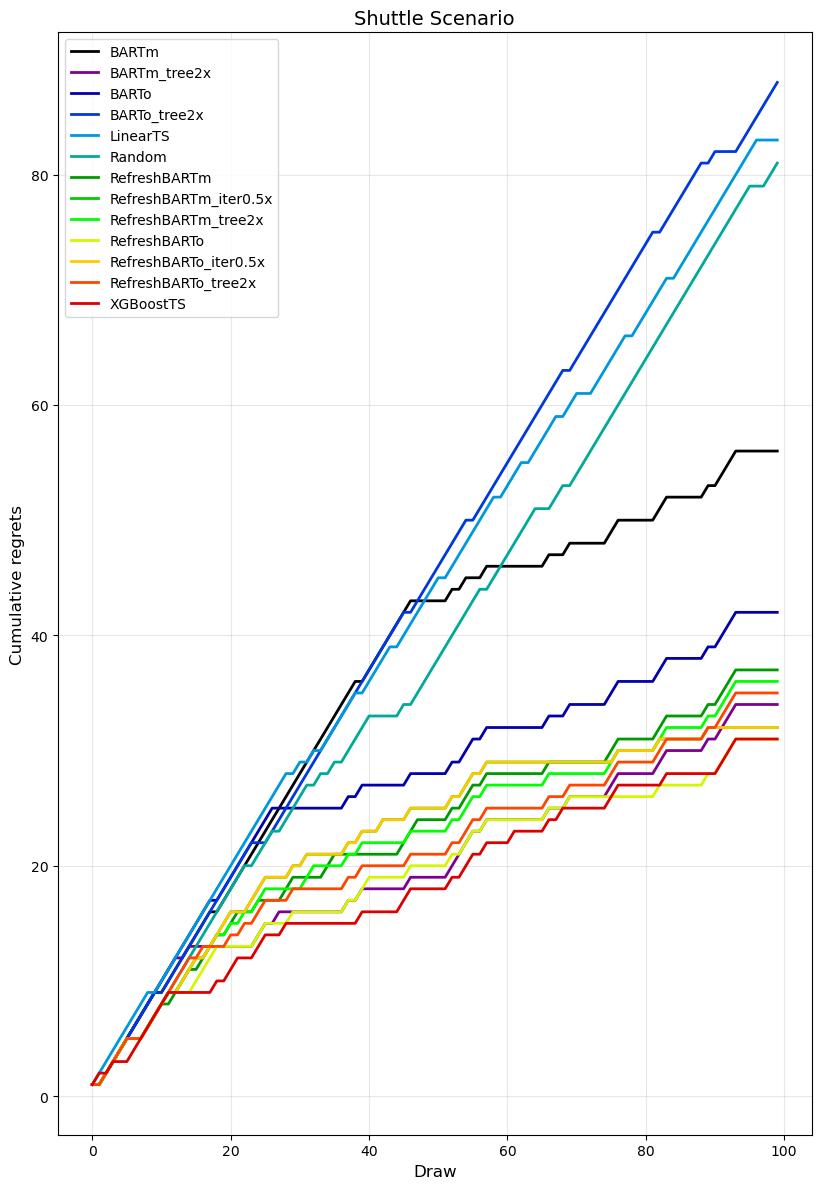

INFO bandit_simulator — Plot saved to ./results/compare_test_nb/agent_comparison_results_Shuttle.png


In [ ]:
results = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    save_loc=f"{results_dir}/agent_comparison_results_{appendix_name}.png"
)
_sim_logger.info(f"Plot saved to {results_dir}/agent_comparison_results_{appendix_name}.png")